In [1]:
from typing import Optional, Sequence
import numpy as np
import pandas as pd
import xarray as xr
from hecdss import HecDss

_MISSING = -3.4028235e38  # DSS float missing for grids

SHG_WKT = (
    'PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",'
    'GEOGCS["GCS_North_American_1983",'
    'DATUM["D_North_American_1983",'
    'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
    'PRIMEM["Greenwich",0.0],'
    'UNIT["Degree",0.0174532925199433]],'
    'PROJECTION["Albers"],'
    'PARAMETER["False_Easting",0.0],'
    'PARAMETER["False_Northing",0.0],'
    'PARAMETER["Central_Meridian",-96.0],'
    'PARAMETER["Standard_Parallel_1",29.5],'
    'PARAMETER["Standard_Parallel_2",45.5],'
    'PARAMETER["Latitude_Of_Origin",23.0],'
    'UNIT["Meter",1.0]]'
)


In [ ]:

def dss_to_3d_array(
    dss_path: str,
    parameter_substring: str = "PRECIPITATION",
    srs_substring: str = "SHG",
    paths_filter: Optional[Sequence[str]] = None,
) -> xr.DataArray:
    """
    Read a gridded DSS file and stack all matching time slices into a 3-D DataArray.

    Parameters
    ----------
    dss_path : str
        Path to the .dss file.
    parameter_substring : str, default "PRECIPITATION"
        Case-insensitive substring used to select catalog paths by parameter (C-part).
    srs_substring : str, default "SHG"
        Case-insensitive substring used to ensure we only read the SHG grids (or your desired grid SRS).
    paths_filter : sequence of str, optional
        If provided, only read these exact DSS paths (bypasses substring filtering).

    Returns
    -------
    xr.DataArray
        DataArray with dims ('time', 'y', 'x') and coords:
          - time : pandas.DatetimeIndex (sorted)
          - x, y : 1-D arrays of cell-center coordinates
        Attributes include 'units', 'cell_size', and 'crs' when available.

    Notes
    -----
    - Assumes each matching DSS record is one grid “time slice”.
    - Replaces DSS grid missing value (-3.4028235e38) with NaN.
    - Grids must all share the same shape, lower-left, and cell size.
    """
    dss = HecDss(dss_path)
    try:
        catalog = dss.get_catalog()

        if paths_filter is not None:
            paths = list(paths_filter)
        else:
            # Filter by parameter and SRS (case-insensitive)
            paths = [
                p for p in catalog.uncondensed_paths
                if (parameter_substring.lower() in p.lower())
            ]

        if not paths:
            raise ValueError(
                f"No DSS paths found in '{dss_path}' matching parameter '{parameter_substring}' "
                f"and SRS '{srs_substring}'."
            )

        # Read all slices
        grids = []
        times = []
        cell_size = None
        ll_x = ll_y = None
        rows = cols = None
        units = None
        crs = None

        for p in paths:
            rec = dss.get(p)

            # Extract grid and clean missing
            g = rec.data.astype(np.float32)
            g[g == _MISSING] = np.nan

            # On first record, record geometry/shape
            if cell_size is None:
                cell_size = float(rec.cellSize)
                # DSS stores lower-left *cell index* (1-based in some writers, 0-based in others);
                # these multiplications give lower-left *corner* in projected units.
                ll_x = float(rec.lowerLeftCellX) * cell_size
                ll_y = float(rec.lowerLeftCellY) * cell_size
                rows, cols = g.shape

                # Optional metadata if present
                units = getattr(rec, "units", units)
                crs = getattr(rec, "srsName", crs) or getattr(rec, "srsDefinition", crs)

            else:
                # Sanity-check shapes / geometry
                if g.shape != (rows, cols):
                    raise ValueError(
                        f"Grid shape mismatch: first grid {rows}x{cols}, path {p} has {g.shape}"
                    )

            # Time stamp from record; try common attrs, fall back to parsing D-part from path
            t = getattr(rec, "startDateTime", None)
            if t is None:
                # DSS paths look like /A/B/C/D/E/F/
                try:
                    d_part = p.strip("/").split("/")[3]  # D-part
                    t = d_part
                except Exception:
                    t = "NaT"

            times.append(pd.to_datetime(t, errors="coerce"))
            grids.append(g)

        # Sort by time (some catalogs are not temporal-ordered)
        times = pd.to_datetime(times)
        order = np.argsort(times.values)
        times = times[order]
        grids = [grids[i] for i in order]

        # Build coordinates (cell centers)
        # lower-left corner + half cell to center of (0,0) then regular spacing
        x0 = ll_x + (cell_size / 2.0)
        y0 = ll_y + (cell_size / 2.0)
        x = x0 + np.arange(cols) * cell_size
        y = y0 + np.arange(rows) * cell_size

        # Stack into 3D: (time, y, x)
        data_3d = np.stack(grids, axis=0)  # shape: (T, rows, cols)

        da = xr.DataArray(
            data_3d,
            dims=("time", "y", "x"),
            coords={"time": times, "y": y, "x": x},
            attrs={
                "units": units or "unknown",
                "cell_size": cell_size,
                "crs": SHG_WKT,  # best-effort label
                "source": dss_path,
            },
        )
        return da

    finally:
        dss.close()


In [17]:
dss_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_Template_Test_iter1_k18_smooth_uf3.dss"
dss = HecDss(dss_path)
catalog = dss.get_catalog()
paths = [p for p in catalog.uncondensed_paths if "PRECIPITATION" in p]
data_list = []
sample_grid = None
cell_size = ll_x = ll_y = None

for path in paths:
    record = dss.get(path)
    grid = record.data.astype(np.float32)
    grid[grid == -3.4028235e38] = np.nan
    data_list.append(grid)

    if sample_grid is None:
        sample_grid = grid
        cell_size = record.cellSize
        ll_x = record.lowerLeftCellX * cell_size
        ll_y = record.lowerLeftCellY * cell_size

dss.close()

16:37:27.560      -----DSS---zopen   Existing file opened,  File: /workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_Template_Test_iter1_k18_smooth_uf3.dss
16:37:27.560                         Handle 74;  Process: 989;  DSS Versions - Software: 7-IU, File:  7-IU
16:37:27.560                         Single-user advisory access mode
16:37:28.235      -----DSS---zclose  Handle 74;  Process: 989;  File: /workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_Template_Test_iter1_k18_smooth_uf3.dss
16:37:28.235                         Number records:         72
16:37:28.235                         File size:              137253  64-bit words
16:37:28.235                         File size:              1072 Kb;  1 Mb
16:37:28.235                         Dead space:             0
16:37:28.235                         Hash range:             8192
16:37:28.235                         Number hash used:       54
16:37:28.235                    

In [18]:
data_stack = np.stack(data_list, axis=0)
cumulative = np.nansum(data_stack, axis=0)

rows, cols = cumulative.shape
#Adjust to cell center instead of corner
x_coords = ll_x + (0.5+np.arange(cols)) * cell_size   
y_coords = ll_y + (0.5+np.arange(rows)) * cell_size 

precip = xr.DataArray(
            cumulative,
            dims=("y", "x"),
            coords={"x": x_coords, "y": y_coords},
            )

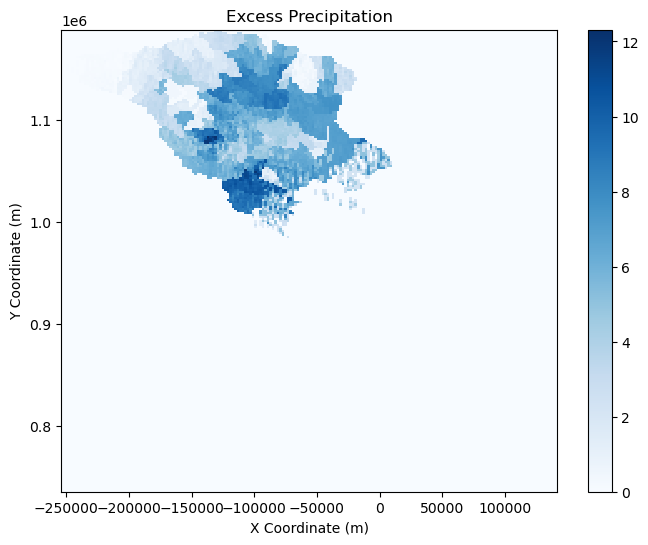

Average excess precipitation: 0.6756 inches


In [19]:
import matplotlib.pyplot as plt

# Assuming your DataArray is called precip

# Plot
plt.figure(figsize=(8, 6))
precip.plot(cmap="Blues")
plt.title("Excess Precipitation")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.show()

# Total and average
total_precip = float(precip.sum(skipna=True))
avg_precip = float(precip.mean(skipna=True))

print(f"Average excess precipitation: {avg_precip:.4f} inches")

In [ ]:
    def _read_dss_cumulative(self, dss_path: str) -> xr.DataArray:
        """Reads a DSS file and returns cumulative precipitation as an xarray.DataArray."""
        dss = HecDss(dss_path)
        catalog = dss.get_catalog()
        paths = [p for p in catalog.uncondensed_paths if "PRECIPITATION" in p and "SHG" in p]
        data_list = []
        sample_grid = None
        cell_size = ll_x = ll_y = None

        for path in paths:
            record = dss.get(path)
            grid = record.data.astype(np.float32)
            grid[grid == -3.4028235e38] = np.nan
            data_list.append(grid)

            if sample_grid is None:
                sample_grid = grid
                cell_size = record.cellSize
                ll_x = record.lowerLeftCellX * cell_size
                ll_y = record.lowerLeftCellY * cell_size

        dss.close()

        data_stack = np.stack(data_list, axis=0)
        cumulative = np.nansum(data_stack, axis=0)

        rows, cols = cumulative.shape
        #Adjust to cell center instead of corner
        x_coords = ll_x + (0.5+np.arange(cols)) * cell_size   
        y_coords = ll_y + (0.5+np.arange(rows)) * cell_size  

        return xr.DataArray(
            cumulative,
            dims=("y", "x"),
            coords={"x": x_coords, "y": y_coords},
            attrs={"units": "mm", "cell_size": cell_size, "crs": self.shg_crs.to_string()},
        )

In [9]:
da3d = dss_to_3d_array("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_iter1_k0.dss")
# da3d.dims -> ('time','y','x')
# da3d.sel(time="2020-05-02 12:00")  # one slice
# da3d.max("time")                   # cumulative max across time

14:58:52.536      -----DSS---zopen   Existing file opened,  File: /workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_iter1_k0.dss
14:58:52.536                         Handle 72;  Process: 1973;  DSS Versions - Software: 7-IU, File:  7-IU
14:58:52.537                         Single-user advisory access mode
14:58:53.303      -----DSS---zclose  Handle 72;  Process: 1973;  File: /workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/ExcessPrecipOutput_iter1_k0.dss
14:58:53.303                         Number records:         72
14:58:53.303                         File size:              47775  64-bit words
14:58:53.303                         File size:              373 Kb;  0 Mb
14:58:53.303                         Dead space:             0
14:58:53.303                         Hash range:             8192
14:58:53.303                         Number hash used:       54
14:58:53.303                         Max paths for hash:     3
14:58:53.303         

In [12]:
da3d.max("time")

<xarray.DataArray (y: 226, x: 198)> Size: 179kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(226, 198), dtype=float32)
Coordinates:
  * y        (y) float64 2kB 7.37e+05 7.39e+05 7.41e+05 ... 1.185e+06 1.187e+06
  * x        (x) float64 2kB -2.53e+05 -2.51e+05 -2.49e+05 ... 1.39e+05 1.41e+05